In [1]:
# Read protocol text file (ASVspoof2017_V2_train.trn, ASVspoof2017_V2_eval.trl, ASVspoof2017_V2_dev.trl)
# take file name, label, id, speech(?)
# Read individual files

### Import Libraries

In [1]:
import pandas as pd
import scipy.fftpack
from scipy.fftpack import dct
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

### File Paths

In [2]:
protocol_dev_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_dev.trl.txt'
protocol_train_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_train.trn.txt'
protocol_eval_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_eval.trl.txt'

In [3]:
folder_dev_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_dev'
folder_train_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_train'
folder_eval_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_eval'

In [4]:
df_dev = pd.read_csv(protocol_dev_file, sep=' ')
df_train = pd.read_csv(protocol_train_file, sep=' ')
df_eval = pd.read_csv(protocol_eval_file, sep=' ')

### File Check

In [5]:
print(df_dev.head())

         file_id     type speaker_id phrase_id environment_id playback_id  \
0  D_1000001.wav  genuine      M0011       S06              -           -   
1  D_1000002.wav  genuine      M0011       S08              -           -   
2  D_1000003.wav  genuine      M0011       S04              -           -   
3  D_1000004.wav  genuine      M0011       S07              -           -   
4  D_1000005.wav  genuine      M0011       S10              -           -   

  recording_id  
0            -  
1            -  
2            -  
3            -  
4            -  


In [6]:
print(df_train.head())

         file_id     type speaker_id phrase_id environment_id playback_id  \
0  T_1000001.wav  genuine      M0002       S05              -           -   
1  T_1000002.wav  genuine      M0002       S09              -           -   
2  T_1000003.wav  genuine      M0002       S01              -           -   
3  T_1000004.wav  genuine      M0002       S10              -           -   
4  T_1000005.wav  genuine      M0002       S04              -           -   

  recording_id  
0            -  
1            -  
2            -  
3            -  
4            -  


In [7]:
print(df_eval.head())

         file_id   type speaker_id phrase_id environment_id playback_id  \
0  E_1000001.wav  spoof      M0029       S03            E19         P22   
1  E_1000002.wav  spoof      M0027       S10            E19         P22   
2  E_1000003.wav  spoof      M0025       S01            E14         P03   
3  E_1000004.wav  spoof      M0035       S10            E12         P16   
4  E_1000005.wav  spoof      M0025       S10            E18         P05   

  recording_id  
0          R22  
1          R22  
2          R04  
3          R11  
4          R03  


In [8]:
dev_labels = df_dev['type'].map({'genuine' : 1, 'spoof' : 0})
train_labels = df_train['type'].map({'genuine' : 1, 'spoof' : 0})
eval_labels = df_eval['type'].map({'genuine' : 1, 'spoof' : 0})

In [9]:
print(dev_labels)

0       1
1       1
2       1
3       1
4       1
       ..
1705    0
1706    0
1707    0
1708    0
1709    0
Name: type, Length: 1710, dtype: int64


In [10]:
print(dev_labels.shape)
print(train_labels.shape)
print(eval_labels.shape)

(1710,)
(3014,)
(13306,)


### Find optimal duration

In [11]:
# Function to get duration of each audio file
def get_audio_durations(folder):
    durations, sample_rates = [], []
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        audio, sr = librosa.load(file_path, sr=None)  # Load audio with its original sampling rate
        duration = librosa.get_duration(y=audio, sr=sr)  # Get the duration of the audio file
        durations.append(duration)
        sample_rates.append(sr)
    return durations, sample_rates

In [12]:
# Get durations for train set
train_durations, train_sr = get_audio_durations(folder_train_file)

In [13]:
unique_values = set(train_sr)
print(unique_values)

{16000}


In [15]:
# Get durations for eval set
eval_durations, eval_sr = get_audio_durations(folder_eval_file)

In [16]:
unique_values = set(eval_sr)
print(unique_values)

{16000}


In [17]:
# Get durations for dev set
dev_durations, dev_sr = get_audio_durations(folder_dev_file)

In [18]:
unique_values = set(dev_sr)
print(unique_values)

{16000}


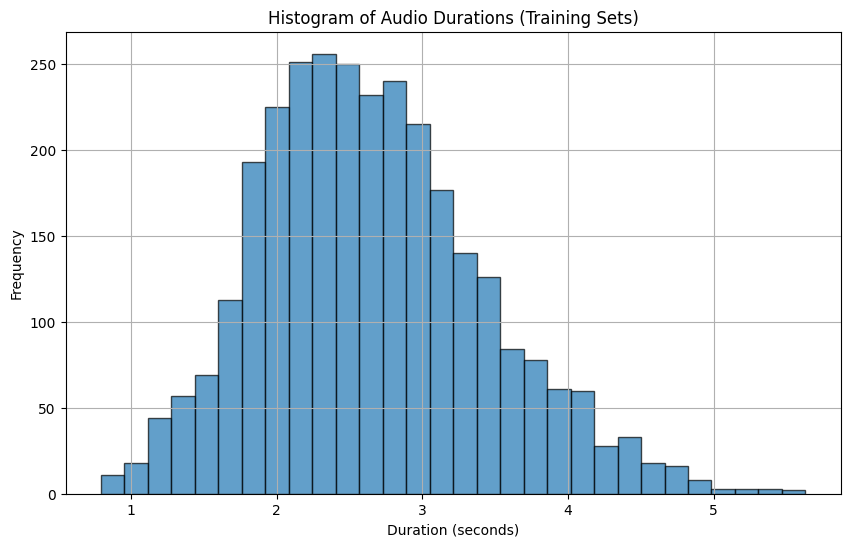

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(train_durations, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Audio Durations (Training Sets)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

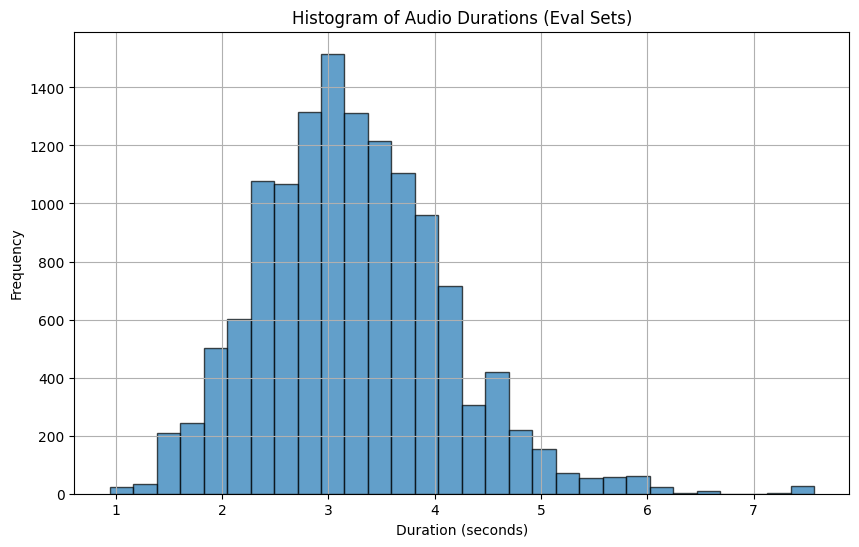

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(eval_durations, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Audio Durations (Eval Sets)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

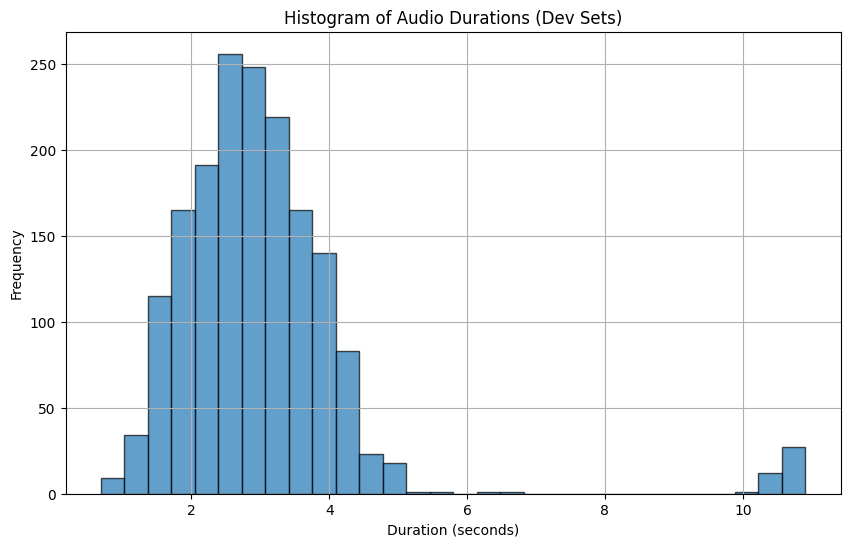

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(dev_durations, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Audio Durations (Dev Sets)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
import numpy as np

In [17]:
# Calculate the median duration from all durations
median_duration = np.median(train_durations)

# Print the median value
print(f"The median audio duration is: {median_duration:.2f} seconds")

The median audio duration is: 2.59 seconds


### Pad & Truncate Audio Files

In [18]:
def pad_and_truncate_audio(audio, target_duration, sample_rate):
    target_length = int(target_duration * sample_rate)
    
    if len(audio) < target_length:
        # Pad the audio with zeros
        pad_width = target_length - len(audio)
        return np.pad(audio, (0, pad_width), mode='constant')
    elif len(audio) > target_length:
        # Truncate the audio
        return audio[:target_length]
    return audio  # If already the correct length, return as is

def pad_and_truncate_files(folder_path):
    new_audio = []
    sample_rate = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        audio, sr = librosa.load(file_path, sr=None)
        processed_audio = pad_and_truncate_audio(audio, median_duration, 16000)
        new_audio.append(processed_audio)
        sample_rate.append(sr)

    return new_audio, sample_rate

In [19]:
train_audio, train_sr = pad_and_truncate_files(folder_train_file)
dev_audio, dev_sr = pad_and_truncate_files(folder_dev_file)
eval_audio, eval_sr = pad_and_truncate_files(folder_eval_file)

In [20]:
print(len(train_audio))
print(len(dev_audio))
print(len(eval_audio))

3014
1710
13306


### Code for LFCC

In [21]:
def pre_emphasis(signal, pre_emphasis_coef=0.97):
    return np.append(signal[0], signal[1:] - pre_emphasis_coef * signal[:-1])

def framing(signal, frame_size, frame_stride, sample_rate):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    return frames

def apply_window(frames):
    hamming_window = np.hamming(frames.shape[1])
    return frames * hamming_window

def power_spectrum(frames, NFFT):
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    return pow_frames

def linear_filter_bank(sample_rate, NFFT, nfilt=26):
    low_freq_mel = 0
    high_freq_mel = sample_rate / 2
    linear_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    
    bins = np.floor((NFFT + 1) * linear_points / sample_rate)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bins[m - 1])   # left
        f_m = int(bins[m])             # center
        f_m_plus = int(bins[m + 1])    # right
        
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
    return fbank

def extract_lfcc(signal, sample_rate, frame_size=0.025, frame_stride=0.01, nfilt=26, NFFT=512, num_ceps=13):
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, frame_size, frame_stride, sample_rate)

    # Step 3: Apply Hamming Window
    windowed_frames = apply_window(frames)

    # Step 4: Power Spectrum
    power_frames = power_spectrum(windowed_frames, NFFT)

    # Step 5: Filter Banks (Linear scale)
    fbank = linear_filter_bank(sample_rate, NFFT, nfilt)
    filter_banks = np.dot(power_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    log_filter_banks = np.log(filter_banks)

    # Step 6: Discrete Cosine Transform (DCT)
    lfcc = dct(log_filter_banks, type=2, axis=1, norm='ortho')[:, :num_ceps]

    return lfcc

### Code for CQCC

In [22]:
def extract_cqcc(signal, sample_rate, bins_per_octave=12, fmin=32.7, num_ceps=13, hop_length=512):
    # Step 1: Calculate the maximum number of bins
    nyquist_freq = sample_rate / 2
    max_bins = int(np.log2(nyquist_freq / fmin) * bins_per_octave)

    # Ensure num_bins does not exceed the maximum allowable number of bins
    num_bins = min(max_bins, 96)  # Limit to 96 bins or less

    # Step 2: Perform Constant-Q Transform (CQT)
    cqt_spectrum = np.abs(librosa.cqt(signal, sr=sample_rate, n_bins=num_bins, bins_per_octave=bins_per_octave, hop_length=hop_length))

    # Step 3: Power Spectrum
    power_spectrum = np.square(cqt_spectrum)

    # Step 4: Logarithm of Power Spectrum
    log_power_spectrum = np.log10(power_spectrum + np.finfo(float).eps)  # Avoid log of zero

    # Step 5: Discrete Cosine Transform (DCT)
    cqcc = dct(log_power_spectrum, type=2, axis=0, norm='ortho')[:num_ceps]

    return cqcc.T  # Transpose to match LFCC dimensions (num_frames, num_ceps)

### Code to extract LFCC and MFCC

In [23]:
def extract_lfcc_features(audio,sr):
    lfcc = extract_lfcc(audio, sr)

    return lfcc

def extract_cqcc_features(audio, sr):
    cqcc = extract_cqcc(audio, sr)
    
    return cqcc

In [24]:
def extract_lfcc_from_folder(audios, srs):
    features_list = []

    for audio, sr in zip(audios, srs):
        features = extract_lfcc_features(audio, sr)
        features_list.append(features)

    return features_list

def extract_cqcc_from_folder(audios, srs):
    features_list = []

    for audio, sr in zip(audios, srs):
        features = extract_cqcc_features(audio, sr)
        features_list.append(features)
        
    return features_list

In [25]:
# dev_lfcc = extract_lfcc_from_folder(dev_audio, dev_sr)
# dev_cqcc = extract_cqcc_from_folder(dev_audio, dev_sr)

In [26]:
# train_lfcc = extract_lfcc_from_folder(train_audio, train_sr)
# train_cqcc = extract_cqcc_from_folder(train_audio, train_sr)

In [27]:
# eval_lfcc = extract_lfcc_from_folder(eval_audio, eval_sr)
# eval_cqcc = extract_cqcc_from_folder(eval_audio, eval_sr)

### Get Names

In [28]:
def get_names(folder_path):
    name_list = []
    for file in os.listdir(folder_path):
        name_list.append(file)
    return name_list

In [29]:
dev_names = get_names(folder_dev_file)
train_names = get_names(folder_train_file)
eval_names = get_names(folder_eval_file)

##### npy save paths

In [30]:
dev_lfcc_path = './Voice Liveness/dev_lfcc.npy'
dev_cqcc_path = './Voice Liveness/dev_cqcc.npy'
train_lfcc_path = './Voice Liveness/train_lfcc.npy'
train_cqcc_path = './Voice Liveness/train_cqcc.npy'
eval_lfcc_path = './Voice Liveness/eval_lfcc.npy'
eval_cqcc_path = './Voice Liveness/eval_cqcc.npy'

In [31]:
# np.save(dev_lfcc_path, np.array(dev_lfcc))
# np.save(dev_cqcc_path, np.array(dev_cqcc))
# np.save(train_lfcc_path, np.array(train_lfcc))
# np.save(train_cqcc_path, np.array(train_cqcc))
# np.save(eval_lfcc_path, np.array(eval_lfcc))
# np.save(eval_cqcc_path, np.array(eval_cqcc))

##### Load npy data

In [32]:
dev_lfcc = np.load(dev_lfcc_path)
dev_cqcc = np.load(dev_cqcc_path)
train_lfcc = np.load(train_lfcc_path)
train_cqcc = np.load(train_cqcc_path)
eval_lfcc = np.load(eval_lfcc_path)
eval_cqcc = np.load(eval_cqcc_path)

In [33]:
print(dev_lfcc.shape)
print(dev_cqcc.shape)
print(train_lfcc.shape)
print(train_cqcc.shape)
print(eval_lfcc.shape)
print(eval_cqcc.shape)

(1710, 562, 13)
(1710, 176, 13)
(3014, 562, 13)
(3014, 176, 13)
(13306, 562, 13)
(13306, 176, 13)


In [34]:
dev_lfcc = dev_lfcc.reshape(dev_lfcc.shape[0], -1)
dev_cqcc = dev_cqcc.reshape(dev_cqcc.shape[0], -1)
train_lfcc = train_lfcc.reshape(train_lfcc.shape[0], -1)
train_cqcc = train_cqcc.reshape(train_cqcc.shape[0], -1)
eval_lfcc = eval_lfcc.reshape(eval_lfcc.shape[0], -1)
eval_cqcc = eval_cqcc.reshape(eval_cqcc.shape[0], -1)

In [35]:
print(dev_lfcc.shape)
print(dev_cqcc.shape)
print(train_lfcc.shape)
print(train_cqcc.shape)
print(eval_lfcc.shape)
print(eval_cqcc.shape)

(1710, 7306)
(1710, 2288)
(3014, 7306)
(3014, 2288)
(13306, 7306)
(13306, 2288)


In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [49]:
# Train an XGB classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_lfcc, train_labels)

# Test the SVM classifier on the test set
xgb_predictions = xgb_classifier.predict(eval_lfcc)

# Evaluate the classifier
accuracy = accuracy_score(eval_labels, xgb_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report
print(classification_report(eval_labels, xgb_predictions))

c:\Users\andre\anaconda3\envs\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 26.77%
              precision    recall  f1-score   support

           0       0.99      0.19      0.32     12008
           1       0.12      0.98      0.21      1298

    accuracy                           0.27     13306
   macro avg       0.55      0.59      0.26     13306
weighted avg       0.91      0.27      0.31     13306



In [50]:
# Train an XGB classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_cqcc, train_labels)

# Test the SVM classifier on the test set
xgb_predictions = xgb_classifier.predict(eval_cqcc)

# Evaluate the classifier
accuracy = accuracy_score(eval_labels, xgb_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report
print(classification_report(eval_labels, xgb_predictions))

c:\Users\andre\anaconda3\envs\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 18.86%
              precision    recall  f1-score   support

           0       1.00      0.10      0.18     12008
           1       0.11      1.00      0.19      1298

    accuracy                           0.19     13306
   macro avg       0.55      0.55      0.19     13306
weighted avg       0.91      0.19      0.18     13306



### GMM for results

In [36]:
from sklearn.mixture import GaussianMixture

In [37]:
genuine_gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
genuine_gmm.fit(train_lfcc)

GaussianMixture(covariance_type='spherical', n_components=2, random_state=42)

In [38]:
train_predictions = genuine_gmm.predict(train_lfcc)
dev_predictions = genuine_gmm.predict(dev_lfcc)
eval_predictions = genuine_gmm.predict(eval_lfcc)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
true_labels_train = train_labels.values

accuracy_dev = accuracy_score(true_labels_train, train_predictions)
print(f'Accuracy on the train set: {accuracy_dev:.2f}')

Accuracy on the train set: 0.44


In [41]:
true_labels_dev = dev_labels.values

accuracy_dev = accuracy_score(true_labels_dev, dev_predictions)
print(f'Accuracy on the development set: {accuracy_dev:.2f}')

Accuracy on the development set: 0.46


In [42]:
true_labels_eval = eval_labels.values

accuracy_eval = accuracy_score(true_labels_eval, eval_predictions)
print(f'Accuracy on the eval set: {accuracy_eval:.2f}')

Accuracy on the eval set: 0.70


In [43]:
genuine_gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
genuine_gmm.fit(train_cqcc)

GaussianMixture(covariance_type='spherical', n_components=2, random_state=42)

In [44]:
train_predictions = genuine_gmm.predict(train_cqcc)
dev_predictions = genuine_gmm.predict(dev_cqcc)
eval_predictions = genuine_gmm.predict(eval_cqcc)

In [45]:
true_labels_train = train_labels.values

accuracy_dev = accuracy_score(true_labels_train, train_predictions)
print(f'Accuracy on the train set: {accuracy_dev:.2f}')

Accuracy on the train set: 0.44


In [46]:
true_labels_dev = dev_labels.values

accuracy_dev = accuracy_score(true_labels_dev, dev_predictions)
print(f'Accuracy on the development set: {accuracy_dev:.2f}')

Accuracy on the development set: 0.47


In [47]:
true_labels_eval = eval_labels.values

accuracy_eval = accuracy_score(true_labels_eval, eval_predictions)
print(f'Accuracy on the eval set: {accuracy_eval:.2f}')

Accuracy on the eval set: 0.69
